## 数据预处理

In [25]:
from torchvision.datasets import ImageFolder
import numpy as np
import torch


# 设置随机数生成器种子
seed = 24
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# 数据集根目录
# data_root = './data/sub_img_dataset/coating_shape'  # 子图数据集
# data_root = './data/color_dataset/coating_color' # 颜色数据集
data_root = './data/dataset_new/coating_shape'
dataset = ImageFolder(root=data_root)

class_names = dataset.classes

print(len(dataset))
print(dataset.class_to_idx)
print(dataset[0])

92
{'bao_tai': 0, 'ni_tai': 1}
(<PIL.Image.Image image mode=RGB size=1343x1420 at 0x258F609E750>, 0)


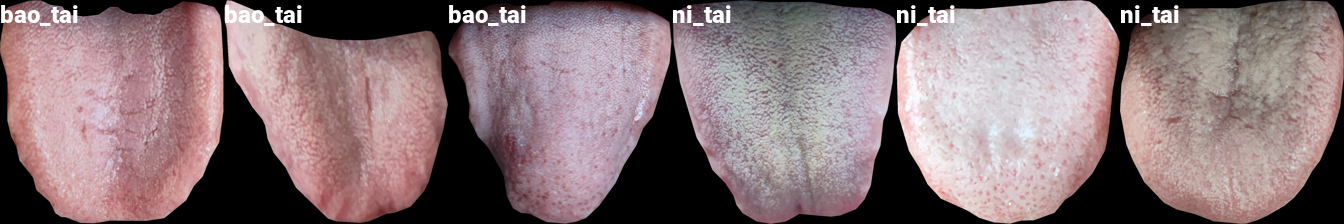

In [26]:
from PIL import Image, ImageDraw, ImageFont
import os
import random


def show_examples(dataset: ImageFolder, examples_per_class=3, size=(224, 224)):
    w, h = size
    labels = dataset.classes
    num_classes = len(labels)

    # 每行至多显示的类别数量
    max_classes_per_row = 2
    # 计算每行显示的示例数量
    examples_per_row = min(
        examples_per_class * max_classes_per_row, num_classes * examples_per_class)
    # 计算显示示例的行数
    num_rows = num_classes * examples_per_class // examples_per_row + (1 if num_classes * examples_per_class % examples_per_row != 0 else 0)
    # 计算网格图像的大小
    grid_size = (examples_per_row * w, num_rows * h)

    grid = Image.new('RGB', size=grid_size, color=(255, 255, 255))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype(
        "C:\\Users\\ChenXi\\fonts\\Roboto\\Roboto-Black.ttf", 24)

    for row in range(num_rows):
        for col in range(max_classes_per_row):
            label_id = row * max_classes_per_row + col
            if label_id >= num_classes:
                break

            label = labels[label_id]

            # 获取该类别的所有图片路径
            class_images = [img_path for img_path,
                            class_label in dataset.imgs if class_label == label_id]

            # 从该类别的所有图片中随机选择 examples_per_class 张图片
            selected_images = random.sample(class_images, min(
                examples_per_class, len(class_images)))

            # 在当前类别的行中绘制图片和标签
            for i, img_path in enumerate(selected_images):
                image = Image.open(img_path)

                # 读取图像的 Exif 信息，获取方向信息
                exif = image._getexif()
                orientation = exif.get(0x0112, 1) if exif else 1

                # 根据方向信息旋转图像
                if orientation == 1:
                    pass
                elif orientation == 3:
                    image = image.rotate(180, expand=True)
                elif orientation == 6:
                    image = image.rotate(270, expand=True)
                elif orientation == 8:
                    image = image.rotate(90, expand=True)

                image = image.resize(size)
                idx = col * examples_per_class + i
                box = (idx * w, row * h)
                grid.paste(image, box=box)
                draw.text(box, label, (255, 255, 255), font=font)  # 在图片上方写标签

    return grid


# 显示数据集示例
show_examples(dataset)

In [27]:
from torchvision.transforms import transforms
from torch.utils.data import DataLoader


dataset_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
data_loader.dataset.transform = dataset_transform
# 获取所有图像数据
all_images = None

for inputs, _ in data_loader:
    all_images = inputs

# 计算数据集的均值和标准差
mean = torch.mean(all_images, dim=(0, 2, 3))
std = torch.std(all_images, dim=(0, 2, 3))

print(f"均值：{mean}")
print(f"标准差：{std}")

均值：tensor([0.4822, 0.4072, 0.4202])
标准差：tensor([0.2910, 0.2603, 0.2679])


In [28]:
from torch.utils.data import random_split
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import TensorDataset


class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)

        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1:y2, x1:x2] = 0

        mask = torch.from_numpy(mask)
        img *= mask.unsqueeze(0)

        return img
    

# 数据增强和预处理
data_augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomApply(transforms.GaussianBlur(3, sigma=(0.1, 2.0)), 0.5),
    Cutout(n_holes=8, length=32),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


# # 计算每个类别的样本数量
# class_counts = torch.bincount(torch.tensor(dataset.targets))

# # 计算每个类别的权重
# class_weights = 1 / class_counts.float()


# 划分数据集
train_size = int(4 / 6.0 * len(dataset))
val_size = int(1 / 6.0 * len(dataset))
test_size = len(dataset) - train_size - val_size
remaining_size = len(dataset) - train_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = data_augmentation_transform
val_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform

# 获取训练集的特征和标签
X_train = []
y_train = []
for inputs, labels in train_dataset:
    X_train.append(inputs.numpy())  # 将张量转换为 numpy 数组
    y_train.append(labels)
X_train = np.array(X_train)
y_train = np.array(y_train)

# 创建 RandomOverSampler 实例
ros = RandomOverSampler(random_state=24)

# 进行过采样
X_resampled, y_resampled = ros.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

# 将特征转换回张量形式
X_resampled = torch.tensor(X_resampled.reshape(-1, *inputs.shape))

# 创建过采样后的训练集
oversampled_train_dataset = TensorDataset(X_resampled, torch.tensor(y_resampled))

# 创建 DataLoader
train_loader = DataLoader(oversampled_train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

In [29]:
# 输出数据集大小
print("过采样后的训练集大小:", len(oversampled_train_dataset))
print("验证集大小:", len(val_dataset))
print("测试集大小:", len(test_dataset))

id2label = {id: label for id, label in enumerate(
    train_dataset.dataset.classes)}
label2id = {label: id for id, label in id2label.items()}

过采样后的训练集大小: 88
验证集大小: 15
测试集大小: 16
torch.Size([8, 3, 224, 224]) torch.Size([8])
tensor([[[-1.6573, -1.6573, -1.6573,  ..., -1.6573, -1.6573, -1.6573],
         [-1.6573, -1.6573, -1.6573,  ..., -1.6573, -1.6573, -1.6573],
         [-1.6573, -1.6573, -1.6573,  ..., -1.6573, -1.6573, -1.6573],
         ...,
         [-1.6573, -1.6573, -1.6573,  ..., -1.6573, -1.6573, -1.6573],
         [-1.6573, -1.6573, -1.6573,  ..., -1.6573, -1.6573, -1.6573],
         [-1.6573, -1.6573, -1.6573,  ..., -1.6573, -1.6573, -1.6573]],

        [[-1.5643, -1.5643, -1.5643,  ..., -1.5643, -1.5643, -1.5643],
         [-1.5643, -1.5643, -1.5643,  ..., -1.5643, -1.5643, -1.5643],
         [-1.5643, -1.5643, -1.5643,  ..., -1.5643, -1.5643, -1.5643],
         ...,
         [-1.5643, -1.5643, -1.5643,  ..., -1.5643, -1.5643, -1.5643],
         [-1.5643, -1.5643, -1.5643,  ..., -1.5643, -1.5643, -1.5643],
         [-1.5643, -1.5643, -1.5643,  ..., -1.5643, -1.5643, -1.5643]],

        [[-1.5685, -1.5685, -1.5685,

In [30]:
from transformers import ViTImageProcessor


# 加载 Vision Transformer 的特征提取器
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTImageProcessor.from_pretrained(
    model_name,
    do_normalize=False,
    do_resize=False,
    do_rescale=False,
    )
# feature_extractor.image_mean = mean
# feature_extractor.image_std = std
feature_extractor

ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": false,
  "do_rescale": false,
  "do_resize": false,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [31]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


def custom_collate(batch):

    # 将样本数据列表拆分为输入和标签
    images, labels = list(zip(*batch))
    inputs = feature_extractor(images, return_tensors='pt')

    inputs['labels'] = torch.tensor(labels)
    inputs['pixel_values'] = torch.stack(
        [input for input in inputs["pixel_values"]])
    return inputs


train_data = MyDataset(train_dataset)
val_data=MyDataset(val_dataset)
test_data=MyDataset(test_dataset)

In [32]:
from transformers import ViTForImageClassification

model_name = "./tongue-disease-classification/coating_shape/checkpoint_on_sub_img"

# model_name 是官方的 transformer 预训练模型

model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(dataset.classes), id2label=id2label,label2id=label2id)

In [33]:
from sklearn.metrics import accuracy_score


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)     
    return dict(accuracy=accuracy_score(predictions, labels))
    # logits, labels = eval_pred
    # predictions = logits.argsort(axis=-1)[:, -5:]  # 获取top-5预测结果
    # # 将标签扩展为与预测结果相同的形状
    # labels_expanded = labels.reshape(-1, 1).repeat(5, axis=1)
    # correct_predictions = (predictions == labels_expanded)  # 判断预测结果是否包含正确标签
    # top5_accuracy = correct_predictions.any(axis=-1).mean()  # 计算top-5准确率
    # return {"accuracy": top5_accuracy}

## 模型训练与超参搜索

In [34]:
from transformers import TrainingArguments, Trainer


def train(train_dataset: Dataset,
          valid_dataset: Dataset,
          pre_model_path: str
          ) -> None:
    """[summary]

    Args:
        train_dataset (Dataset): [训练集]
        valid_dataset (Dataset): [验证集]
        pre_model_path (str): [预训练模型文件夹]

    Returns:
        [type]: [description]
    """

    args = TrainingArguments(
        report_to="none",
        output_dir=f"tongue-disease-classification/coating_shape/final_model",
        remove_unused_columns=False,
        save_strategy="epoch",
        evaluation_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=30,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_dir='logs',
        warmup_ratio=0.1,
        logging_steps=10,
        seed=seed,
    )

    # 每次训练都要重新载入模型，定义一个函数返回初始化的预训练模型
    def model_init():
        return ViTForImageClassification.from_pretrained(pre_model_path, num_labels=len(dataset.classes), id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)

    # 定义一个trainer
    trainer = Trainer(
        # 注意此处不是model
        model_init=model_init,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        data_collator=custom_collate,
        compute_metrics=compute_metrics,
        tokenizer=feature_extractor,
    )

    # 超参数搜索范围
    def hp_space(trial):
        return {
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
            "weight_decay": trial.suggest_float("weight_decay", 0.01, 0.3),
            "num_train_epochs": trial.suggest_int("num_train_epochs", 8, 20),
            "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16, 32]),
        }

    # trainer.hyperparameter_search方法进行超参数搜索
    best_trial = trainer.hyperparameter_search(
        direction="maximize",
        backend="optuna",
        n_trials=12,
        hp_space=hp_space,
    )

    print("*************************************")
    print(" Best run %s" % str(best_trial))
    print("*************************************")


train_results = train(train_data, val_data, model_name)

c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
[I 2024-05-07 10:49:32,681] A new study created in memory with name: no-name-c0e099c4-c10e-4f59-adc3-648e597cc47c


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 3.7092792987823486, 'eval_accuracy': 0.06666666666666667, 'eval_runtime': 0.3905, 'eval_samples_per_second': 38.411, 'eval_steps_per_second': 5.121, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 3.122220277786255, 'eval_accuracy': 0.06666666666666667, 'eval_runtime': 0.406, 'eval_samples_per_second': 36.941, 'eval_steps_per_second': 4.926, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.6932133436203003, 'eval_accuracy': 0.13333333333333333, 'eval_runtime': 0.4025, 'eval_samples_per_second': 37.268, 'eval_steps_per_second': 4.969, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6303781270980835, 'eval_accuracy': 0.6, 'eval_runtime': 0.3936, 'eval_samples_per_second': 38.111, 'eval_steps_per_second': 5.082, 'epoch': 4.0}
{'loss': 1.7386, 'grad_norm': 2.141204833984375, 'learning_rate': 1.0464313005229278e-05, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2905874252319336, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.3911, 'eval_samples_per_second': 38.352, 'eval_steps_per_second': 5.114, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.26323920488357544, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.3926, 'eval_samples_per_second': 38.206, 'eval_steps_per_second': 5.094, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.26857587695121765, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.3931, 'eval_samples_per_second': 38.159, 'eval_steps_per_second': 5.088, 'epoch': 7.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3102773129940033, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.3916, 'eval_samples_per_second': 38.304, 'eval_steps_per_second': 5.107, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.4111112058162689, 'eval_accuracy': 0.8, 'eval_runtime': 0.4093, 'eval_samples_per_second': 36.649, 'eval_steps_per_second': 4.887, 'epoch': 9.0}
{'loss': 0.3747, 'grad_norm': 1.8759222030639648, 'learning_rate': 6.727058360504536e-06, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.49640509486198425, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4084, 'eval_samples_per_second': 36.731, 'eval_steps_per_second': 4.897, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.504570484161377, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4111, 'eval_samples_per_second': 36.484, 'eval_steps_per_second': 4.865, 'epoch': 11.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.4536571204662323, 'eval_accuracy': 0.8, 'eval_runtime': 0.4095, 'eval_samples_per_second': 36.634, 'eval_steps_per_second': 4.885, 'epoch': 12.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.39125871658325195, 'eval_accuracy': 0.8, 'eval_runtime': 0.4081, 'eval_samples_per_second': 36.757, 'eval_steps_per_second': 4.901, 'epoch': 13.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3440633714199066, 'eval_accuracy': 0.8666666666666667, 'eval_runtime': 0.4101, 'eval_samples_per_second': 36.577, 'eval_steps_per_second': 4.877, 'epoch': 14.0}
{'loss': 0.2442, 'grad_norm': 2.1762893199920654, 'learning_rate': 2.9898037157797935e-06, 'epoch': 15.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3335064649581909, 'eval_accuracy': 0.8666666666666667, 'eval_runtime': 0.4053, 'eval_samples_per_second': 37.005, 'eval_steps_per_second': 4.934, 'epoch': 15.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.33590468764305115, 'eval_accuracy': 0.8666666666666667, 'eval_runtime': 0.4084, 'eval_samples_per_second': 36.733, 'eval_steps_per_second': 4.898, 'epoch': 16.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.34781134128570557, 'eval_accuracy': 0.8666666666666667, 'eval_runtime': 0.407, 'eval_samples_per_second': 36.858, 'eval_steps_per_second': 4.914, 'epoch': 17.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.35872724652290344, 'eval_accuracy': 0.8, 'eval_runtime': 0.4063, 'eval_samples_per_second': 36.917, 'eval_steps_per_second': 4.922, 'epoch': 18.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.36462175846099854, 'eval_accuracy': 0.8, 'eval_runtime': 0.4106, 'eval_samples_per_second': 36.532, 'eval_steps_per_second': 4.871, 'epoch': 19.0}


[I 2024-05-07 10:50:33,912] Trial 0 finished with value: 0.8 and parameters: {'learning_rate': 1.2706665792064123e-05, 'weight_decay': 0.046569603988214414, 'num_train_epochs': 19, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.8.


{'train_runtime': 60.7124, 'train_samples_per_second': 19.09, 'train_steps_per_second': 0.626, 'train_loss': 0.6594355796512804, 'epoch': 19.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/224 [00:00<?, ?it/s]

{'loss': 2.4572, 'grad_norm': 17.698301315307617, 'learning_rate': 7.992212971573471e-06, 'epoch': 0.62}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3568975329399109, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.415, 'eval_samples_per_second': 36.143, 'eval_steps_per_second': 4.819, 'epoch': 1.0}
{'loss': 0.7385, 'grad_norm': 1.6464171409606934, 'learning_rate': 1.5984425943146942e-05, 'epoch': 1.25}
{'loss': 0.4309, 'grad_norm': 5.013851642608643, 'learning_rate': 1.7741917551821308e-05, 'epoch': 1.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2794179618358612, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.3912, 'eval_samples_per_second': 38.343, 'eval_steps_per_second': 5.112, 'epoch': 2.0}
{'loss': 0.3139, 'grad_norm': 1.5824302434921265, 'learning_rate': 1.68273857192532e-05, 'epoch': 2.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.22524157166481018, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.3962, 'eval_samples_per_second': 37.86, 'eval_steps_per_second': 5.048, 'epoch': 3.0}
{'loss': 0.3041, 'grad_norm': 1.0643781423568726, 'learning_rate': 1.591285388668509e-05, 'epoch': 3.12}
{'loss': 0.1756, 'grad_norm': 1.399157166481018, 'learning_rate': 1.499832205411698e-05, 'epoch': 3.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.4774573743343353, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.3929, 'eval_samples_per_second': 38.177, 'eval_steps_per_second': 5.09, 'epoch': 4.0}
{'loss': 0.1688, 'grad_norm': 0.2963027060031891, 'learning_rate': 1.4083790221548872e-05, 'epoch': 4.38}
{'loss': 0.0887, 'grad_norm': 0.2888210117816925, 'learning_rate': 1.3169258388980763e-05, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.33413171768188477, 'eval_accuracy': 0.8666666666666667, 'eval_runtime': 0.3933, 'eval_samples_per_second': 38.14, 'eval_steps_per_second': 5.085, 'epoch': 5.0}
{'loss': 0.0336, 'grad_norm': 0.36877915263175964, 'learning_rate': 1.2254726556412654e-05, 'epoch': 5.62}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.33107438683509827, 'eval_accuracy': 0.8666666666666667, 'eval_runtime': 0.4086, 'eval_samples_per_second': 36.707, 'eval_steps_per_second': 4.894, 'epoch': 6.0}
{'loss': 0.0712, 'grad_norm': 0.15695682168006897, 'learning_rate': 1.1340194723844547e-05, 'epoch': 6.25}
{'loss': 0.0273, 'grad_norm': 0.3053685426712036, 'learning_rate': 1.0425662891276438e-05, 'epoch': 6.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2949574887752533, 'eval_accuracy': 0.8666666666666667, 'eval_runtime': 0.4177, 'eval_samples_per_second': 35.911, 'eval_steps_per_second': 4.788, 'epoch': 7.0}
{'loss': 0.0181, 'grad_norm': 0.2645869553089142, 'learning_rate': 9.511131058708329e-06, 'epoch': 7.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2801388204097748, 'eval_accuracy': 0.8666666666666667, 'eval_runtime': 0.4131, 'eval_samples_per_second': 36.309, 'eval_steps_per_second': 4.841, 'epoch': 8.0}
{'loss': 0.0164, 'grad_norm': 0.11780654639005661, 'learning_rate': 8.59659922614022e-06, 'epoch': 8.12}
{'loss': 0.0159, 'grad_norm': 0.16680411994457245, 'learning_rate': 7.682067393572113e-06, 'epoch': 8.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.24601666629314423, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4193, 'eval_samples_per_second': 35.774, 'eval_steps_per_second': 4.77, 'epoch': 9.0}
{'loss': 0.0148, 'grad_norm': 0.13299481570720673, 'learning_rate': 6.767535561004004e-06, 'epoch': 9.38}
{'loss': 0.0144, 'grad_norm': 0.15813417732715607, 'learning_rate': 5.853003728435895e-06, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.24451081454753876, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4144, 'eval_samples_per_second': 36.201, 'eval_steps_per_second': 4.827, 'epoch': 10.0}
{'loss': 0.0137, 'grad_norm': 0.10413505136966705, 'learning_rate': 4.9384718958677866e-06, 'epoch': 10.62}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.25149253010749817, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4051, 'eval_samples_per_second': 37.03, 'eval_steps_per_second': 4.937, 'epoch': 11.0}
{'loss': 0.014, 'grad_norm': 0.13892531394958496, 'learning_rate': 4.023940063299678e-06, 'epoch': 11.25}
{'loss': 0.0126, 'grad_norm': 0.09419388324022293, 'learning_rate': 3.1094082307315695e-06, 'epoch': 11.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2518776059150696, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.403, 'eval_samples_per_second': 37.223, 'eval_steps_per_second': 4.963, 'epoch': 12.0}
{'loss': 0.0131, 'grad_norm': 0.11660229414701462, 'learning_rate': 2.1948763981634605e-06, 'epoch': 12.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.24732926487922668, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4014, 'eval_samples_per_second': 37.369, 'eval_steps_per_second': 4.983, 'epoch': 13.0}
{'loss': 0.0132, 'grad_norm': 0.09618780761957169, 'learning_rate': 1.2803445655953522e-06, 'epoch': 13.12}
{'loss': 0.0125, 'grad_norm': 0.10830195248126984, 'learning_rate': 3.658127330272434e-07, 'epoch': 13.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.24615474045276642, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4066, 'eval_samples_per_second': 36.893, 'eval_steps_per_second': 4.919, 'epoch': 14.0}


[I 2024-05-07 10:51:25,238] Trial 1 finished with value: 0.9333333333333333 and parameters: {'learning_rate': 1.8382089834618983e-05, 'weight_decay': 0.18217721507450452, 'num_train_epochs': 14, 'per_device_train_batch_size': 4}. Best is trial 1 with value: 0.9333333333333333.


{'train_runtime': 50.6337, 'train_samples_per_second': 16.866, 'train_steps_per_second': 4.424, 'train_loss': 0.22202930875521684, 'epoch': 14.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/320 [00:00<?, ?it/s]

{'loss': 2.5411, 'grad_norm': 16.844118118286133, 'learning_rate': 5.305835424852218e-06, 'epoch': 0.62}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.1832095384597778, 'eval_accuracy': 0.26666666666666666, 'eval_runtime': 0.4062, 'eval_samples_per_second': 36.928, 'eval_steps_per_second': 4.924, 'epoch': 1.0}
{'loss': 1.1122, 'grad_norm': 7.084108352661133, 'learning_rate': 1.0611670849704437e-05, 'epoch': 1.25}
{'loss': 0.4323, 'grad_norm': 2.2326245307922363, 'learning_rate': 1.5917506274556654e-05, 'epoch': 1.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.23544244468212128, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.3884, 'eval_samples_per_second': 38.62, 'eval_steps_per_second': 5.149, 'epoch': 2.0}
{'loss': 0.3654, 'grad_norm': 1.5801560878753662, 'learning_rate': 1.6507043543984678e-05, 'epoch': 2.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.43948692083358765, 'eval_accuracy': 0.8, 'eval_runtime': 0.4072, 'eval_samples_per_second': 36.841, 'eval_steps_per_second': 4.912, 'epoch': 3.0}
{'loss': 0.2681, 'grad_norm': 4.492835998535156, 'learning_rate': 1.5917506274556654e-05, 'epoch': 3.12}
{'loss': 0.1541, 'grad_norm': 4.015239238739014, 'learning_rate': 1.532796900512863e-05, 'epoch': 3.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3624521493911743, 'eval_accuracy': 0.8, 'eval_runtime': 0.409, 'eval_samples_per_second': 36.678, 'eval_steps_per_second': 4.89, 'epoch': 4.0}
{'loss': 0.144, 'grad_norm': 0.2817046046257019, 'learning_rate': 1.4738431735700606e-05, 'epoch': 4.38}
{'loss': 0.0981, 'grad_norm': 0.2512701153755188, 'learning_rate': 1.4148894466272582e-05, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5899699330329895, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.417, 'eval_samples_per_second': 35.97, 'eval_steps_per_second': 4.796, 'epoch': 5.0}
{'loss': 0.0257, 'grad_norm': 0.22000619769096375, 'learning_rate': 1.3559357196844558e-05, 'epoch': 5.62}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2979353666305542, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4015, 'eval_samples_per_second': 37.356, 'eval_steps_per_second': 4.981, 'epoch': 6.0}
{'loss': 0.0552, 'grad_norm': 0.15622161328792572, 'learning_rate': 1.2969819927416533e-05, 'epoch': 6.25}
{'loss': 0.0229, 'grad_norm': 0.20745673775672913, 'learning_rate': 1.2380282657988509e-05, 'epoch': 6.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6071237325668335, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.414, 'eval_samples_per_second': 36.228, 'eval_steps_per_second': 4.83, 'epoch': 7.0}
{'loss': 0.0168, 'grad_norm': 0.15091575682163239, 'learning_rate': 1.1790745388560485e-05, 'epoch': 7.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.28485044836997986, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4018, 'eval_samples_per_second': 37.334, 'eval_steps_per_second': 4.978, 'epoch': 8.0}
{'loss': 0.0149, 'grad_norm': 0.10946251451969147, 'learning_rate': 1.120120811913246e-05, 'epoch': 8.12}
{'loss': 0.014, 'grad_norm': 0.1427702158689499, 'learning_rate': 1.0611670849704437e-05, 'epoch': 8.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2975391149520874, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4025, 'eval_samples_per_second': 37.267, 'eval_steps_per_second': 4.969, 'epoch': 9.0}
{'loss': 0.0132, 'grad_norm': 0.10918904840946198, 'learning_rate': 1.0022133580276413e-05, 'epoch': 9.38}
{'loss': 0.0126, 'grad_norm': 0.14557795226573944, 'learning_rate': 9.432596310848389e-06, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.299066424369812, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4019, 'eval_samples_per_second': 37.318, 'eval_steps_per_second': 4.976, 'epoch': 10.0}
{'loss': 0.0119, 'grad_norm': 0.09344134479761124, 'learning_rate': 8.843059041420365e-06, 'epoch': 10.62}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3143538236618042, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4078, 'eval_samples_per_second': 36.781, 'eval_steps_per_second': 4.904, 'epoch': 11.0}
{'loss': 0.012, 'grad_norm': 0.10671363770961761, 'learning_rate': 8.253521771992339e-06, 'epoch': 11.25}
{'loss': 0.0108, 'grad_norm': 0.08299765735864639, 'learning_rate': 7.663984502564315e-06, 'epoch': 11.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.31292521953582764, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4236, 'eval_samples_per_second': 35.407, 'eval_steps_per_second': 4.721, 'epoch': 12.0}
{'loss': 0.0111, 'grad_norm': 0.096409372985363, 'learning_rate': 7.074447233136291e-06, 'epoch': 12.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.30212342739105225, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4083, 'eval_samples_per_second': 36.734, 'eval_steps_per_second': 4.898, 'epoch': 13.0}
{'loss': 0.0108, 'grad_norm': 0.07999324053525925, 'learning_rate': 6.484909963708266e-06, 'epoch': 13.12}
{'loss': 0.0102, 'grad_norm': 0.08878326416015625, 'learning_rate': 5.895372694280242e-06, 'epoch': 13.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.30847135186195374, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4079, 'eval_samples_per_second': 36.77, 'eval_steps_per_second': 4.903, 'epoch': 14.0}
{'loss': 0.0102, 'grad_norm': 0.08785289525985718, 'learning_rate': 5.305835424852218e-06, 'epoch': 14.38}
{'loss': 0.01, 'grad_norm': 0.15230387449264526, 'learning_rate': 4.716298155424194e-06, 'epoch': 15.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.31451860070228577, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4003, 'eval_samples_per_second': 37.471, 'eval_steps_per_second': 4.996, 'epoch': 15.0}
{'loss': 0.0097, 'grad_norm': 0.0865149274468422, 'learning_rate': 4.1267608859961695e-06, 'epoch': 15.62}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3034651577472687, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.415, 'eval_samples_per_second': 36.141, 'eval_steps_per_second': 4.819, 'epoch': 16.0}
{'loss': 0.0098, 'grad_norm': 0.08069165050983429, 'learning_rate': 3.5372236165681455e-06, 'epoch': 16.25}
{'loss': 0.0095, 'grad_norm': 0.07867130637168884, 'learning_rate': 2.947686347140121e-06, 'epoch': 16.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.303716242313385, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4199, 'eval_samples_per_second': 35.727, 'eval_steps_per_second': 4.764, 'epoch': 17.0}
{'loss': 0.0099, 'grad_norm': 0.09104237705469131, 'learning_rate': 2.358149077712097e-06, 'epoch': 17.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.30865126848220825, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.41, 'eval_samples_per_second': 36.588, 'eval_steps_per_second': 4.878, 'epoch': 18.0}
{'loss': 0.0092, 'grad_norm': 0.0775592029094696, 'learning_rate': 1.7686118082840728e-06, 'epoch': 18.12}
{'loss': 0.0092, 'grad_norm': 0.07166759669780731, 'learning_rate': 1.1790745388560486e-06, 'epoch': 18.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.30911681056022644, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4051, 'eval_samples_per_second': 37.025, 'eval_steps_per_second': 4.937, 'epoch': 19.0}
{'loss': 0.0095, 'grad_norm': 0.0703960582613945, 'learning_rate': 5.895372694280243e-07, 'epoch': 19.38}
{'loss': 0.0093, 'grad_norm': 0.06872355192899704, 'learning_rate': 0.0, 'epoch': 20.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3094837963581085, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4142, 'eval_samples_per_second': 36.214, 'eval_steps_per_second': 4.828, 'epoch': 20.0}


[I 2024-05-07 10:52:38,586] Trial 2 finished with value: 0.9333333333333333 and parameters: {'learning_rate': 1.69786733595271e-05, 'weight_decay': 0.09977845557748279, 'num_train_epochs': 20, 'per_device_train_batch_size': 4}. Best is trial 1 with value: 0.9333333333333333.


{'train_runtime': 72.7767, 'train_samples_per_second': 16.764, 'train_steps_per_second': 4.397, 'train_loss': 0.17042639777064322, 'epoch': 20.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 3.65382719039917, 'eval_accuracy': 0.06666666666666667, 'eval_runtime': 0.41, 'eval_samples_per_second': 36.588, 'eval_steps_per_second': 4.878, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 2.366626024246216, 'eval_accuracy': 0.06666666666666667, 'eval_runtime': 0.4151, 'eval_samples_per_second': 36.138, 'eval_steps_per_second': 4.818, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.49172937870025635, 'eval_accuracy': 0.8, 'eval_runtime': 0.4139, 'eval_samples_per_second': 36.242, 'eval_steps_per_second': 4.832, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.24128250777721405, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4046, 'eval_samples_per_second': 37.078, 'eval_steps_per_second': 4.944, 'epoch': 4.0}
{'loss': 1.4959, 'grad_norm': 4.158029556274414, 'learning_rate': 1.7855526491823375e-05, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2417905330657959, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.3987, 'eval_samples_per_second': 37.618, 'eval_steps_per_second': 5.016, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.30712398886680603, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4075, 'eval_samples_per_second': 36.806, 'eval_steps_per_second': 4.907, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.4545901417732239, 'eval_accuracy': 0.8, 'eval_runtime': 0.4057, 'eval_samples_per_second': 36.974, 'eval_steps_per_second': 4.93, 'epoch': 7.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5293046236038208, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.4091, 'eval_samples_per_second': 36.666, 'eval_steps_per_second': 4.889, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.4522436857223511, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4114, 'eval_samples_per_second': 36.459, 'eval_steps_per_second': 4.861, 'epoch': 9.0}
{'loss': 0.312, 'grad_norm': 1.2706506252288818, 'learning_rate': 1.14785527447436e-05, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.33752670884132385, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4084, 'eval_samples_per_second': 36.733, 'eval_steps_per_second': 4.898, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3009718060493469, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4067, 'eval_samples_per_second': 36.88, 'eval_steps_per_second': 4.917, 'epoch': 11.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.31857025623321533, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4029, 'eval_samples_per_second': 37.228, 'eval_steps_per_second': 4.964, 'epoch': 12.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3752075433731079, 'eval_accuracy': 0.8, 'eval_runtime': 0.4054, 'eval_samples_per_second': 36.999, 'eval_steps_per_second': 4.933, 'epoch': 13.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3978809714317322, 'eval_accuracy': 0.8, 'eval_runtime': 0.4082, 'eval_samples_per_second': 36.751, 'eval_steps_per_second': 4.9, 'epoch': 14.0}
{'loss': 0.1568, 'grad_norm': 1.2830898761749268, 'learning_rate': 5.101578997663822e-06, 'epoch': 15.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.4053893983364105, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4089, 'eval_samples_per_second': 36.686, 'eval_steps_per_second': 4.891, 'epoch': 15.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3753170967102051, 'eval_accuracy': 0.8, 'eval_runtime': 0.4057, 'eval_samples_per_second': 36.969, 'eval_steps_per_second': 4.929, 'epoch': 16.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.357721209526062, 'eval_accuracy': 0.8, 'eval_runtime': 0.4079, 'eval_samples_per_second': 36.773, 'eval_steps_per_second': 4.903, 'epoch': 17.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.34168949723243713, 'eval_accuracy': 0.8, 'eval_runtime': 0.407, 'eval_samples_per_second': 36.856, 'eval_steps_per_second': 4.914, 'epoch': 18.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3349805176258087, 'eval_accuracy': 0.8, 'eval_runtime': 0.4064, 'eval_samples_per_second': 36.913, 'eval_steps_per_second': 4.922, 'epoch': 19.0}


[I 2024-05-07 10:53:40,840] Trial 3 finished with value: 0.8 and parameters: {'learning_rate': 2.1681710740071243e-05, 'weight_decay': 0.021420592376272227, 'num_train_epochs': 19, 'per_device_train_batch_size': 32}. Best is trial 1 with value: 0.9333333333333333.


{'train_runtime': 61.5849, 'train_samples_per_second': 18.82, 'train_steps_per_second': 0.617, 'train_loss': 0.5388511638892325, 'epoch': 19.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 3.184783458709717, 'eval_accuracy': 0.06666666666666667, 'eval_runtime': 0.4063, 'eval_samples_per_second': 36.92, 'eval_steps_per_second': 4.923, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.37333840131759644, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4123, 'eval_samples_per_second': 36.379, 'eval_steps_per_second': 4.851, 'epoch': 2.0}
{'loss': 1.7332, 'grad_norm': 4.675738334655762, 'learning_rate': 1.700305406165473e-05, 'epoch': 2.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.23945750296115875, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4074, 'eval_samples_per_second': 36.822, 'eval_steps_per_second': 4.91, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3957098424434662, 'eval_accuracy': 0.8666666666666667, 'eval_runtime': 0.4076, 'eval_samples_per_second': 36.801, 'eval_steps_per_second': 4.907, 'epoch': 4.0}
{'loss': 0.4625, 'grad_norm': 4.284773826599121, 'learning_rate': 1.3602443249323782e-05, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5297401547431946, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4083, 'eval_samples_per_second': 36.741, 'eval_steps_per_second': 4.899, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.36423924565315247, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4089, 'eval_samples_per_second': 36.683, 'eval_steps_per_second': 4.891, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.26381781697273254, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4105, 'eval_samples_per_second': 36.538, 'eval_steps_per_second': 4.872, 'epoch': 7.0}
{'loss': 0.2867, 'grad_norm': 1.5266997814178467, 'learning_rate': 1.0201832436992838e-05, 'epoch': 7.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.30717790126800537, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4057, 'eval_samples_per_second': 36.972, 'eval_steps_per_second': 4.93, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.4380636215209961, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4017, 'eval_samples_per_second': 37.34, 'eval_steps_per_second': 4.979, 'epoch': 9.0}
{'loss': 0.1674, 'grad_norm': 1.1770045757293701, 'learning_rate': 6.801221624661891e-06, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.39219406247138977, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4049, 'eval_samples_per_second': 37.046, 'eval_steps_per_second': 4.94, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.29836586117744446, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4057, 'eval_samples_per_second': 36.976, 'eval_steps_per_second': 4.93, 'epoch': 11.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2787707448005676, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4032, 'eval_samples_per_second': 37.205, 'eval_steps_per_second': 4.961, 'epoch': 12.0}
{'loss': 0.1102, 'grad_norm': 2.187957286834717, 'learning_rate': 3.4006108123309454e-06, 'epoch': 12.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3002418279647827, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4063, 'eval_samples_per_second': 36.92, 'eval_steps_per_second': 4.923, 'epoch': 13.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.30406829714775085, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4067, 'eval_samples_per_second': 36.885, 'eval_steps_per_second': 4.918, 'epoch': 14.0}
{'loss': 0.0876, 'grad_norm': 2.531562566757202, 'learning_rate': 0.0, 'epoch': 15.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3164055645465851, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4023, 'eval_samples_per_second': 37.282, 'eval_steps_per_second': 4.971, 'epoch': 15.0}


[I 2024-05-07 10:54:29,624] Trial 4 finished with value: 0.9333333333333333 and parameters: {'learning_rate': 1.8363298386587106e-05, 'weight_decay': 0.100855578343004, 'num_train_epochs': 15, 'per_device_train_batch_size': 16}. Best is trial 1 with value: 0.9333333333333333.


{'train_runtime': 48.1181, 'train_samples_per_second': 19.016, 'train_steps_per_second': 1.247, 'train_loss': 0.4745908319950104, 'epoch': 15.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 3.3400423526763916, 'eval_accuracy': 0.06666666666666667, 'eval_runtime': 0.4015, 'eval_samples_per_second': 37.362, 'eval_steps_per_second': 4.982, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

[I 2024-05-07 10:54:36,016] Trial 5 pruned. 


{'eval_loss': 0.6608682870864868, 'eval_accuracy': 0.4666666666666667, 'eval_runtime': 0.4115, 'eval_samples_per_second': 36.448, 'eval_steps_per_second': 4.86, 'epoch': 2.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 3.1730446815490723, 'eval_accuracy': 0.06666666666666667, 'eval_runtime': 0.3898, 'eval_samples_per_second': 38.485, 'eval_steps_per_second': 5.131, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

[I 2024-05-07 10:54:42,290] Trial 6 pruned. 


{'eval_loss': 0.46796175837516785, 'eval_accuracy': 0.8, 'eval_runtime': 0.3911, 'eval_samples_per_second': 38.356, 'eval_steps_per_second': 5.114, 'epoch': 2.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 3.541982412338257, 'eval_accuracy': 0.06666666666666667, 'eval_runtime': 0.3951, 'eval_samples_per_second': 37.969, 'eval_steps_per_second': 5.063, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.2107845544815063, 'eval_accuracy': 0.26666666666666666, 'eval_runtime': 0.3958, 'eval_samples_per_second': 37.894, 'eval_steps_per_second': 5.052, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.29057273268699646, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4036, 'eval_samples_per_second': 37.163, 'eval_steps_per_second': 4.955, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.32885658740997314, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4034, 'eval_samples_per_second': 37.188, 'eval_steps_per_second': 4.958, 'epoch': 4.0}
{'loss': 1.2915, 'grad_norm': 1.526049256324768, 'learning_rate': 1.986485755138353e-05, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5103529095649719, 'eval_accuracy': 0.6, 'eval_runtime': 0.4064, 'eval_samples_per_second': 36.905, 'eval_steps_per_second': 4.921, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.4382883310317993, 'eval_accuracy': 0.8, 'eval_runtime': 0.4056, 'eval_samples_per_second': 36.979, 'eval_steps_per_second': 4.931, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3114316165447235, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.3998, 'eval_samples_per_second': 37.517, 'eval_steps_per_second': 5.002, 'epoch': 7.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3148713707923889, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4073, 'eval_samples_per_second': 36.829, 'eval_steps_per_second': 4.911, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3840777575969696, 'eval_accuracy': 0.8, 'eval_runtime': 0.407, 'eval_samples_per_second': 36.855, 'eval_steps_per_second': 4.914, 'epoch': 9.0}
{'loss': 0.2197, 'grad_norm': 0.9099295735359192, 'learning_rate': 8.82882557839268e-06, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.39889729022979736, 'eval_accuracy': 0.8, 'eval_runtime': 0.4059, 'eval_samples_per_second': 36.959, 'eval_steps_per_second': 4.928, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3726321756839752, 'eval_accuracy': 0.8, 'eval_runtime': 0.4043, 'eval_samples_per_second': 37.105, 'eval_steps_per_second': 4.947, 'epoch': 11.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.34451597929000854, 'eval_accuracy': 0.8, 'eval_runtime': 0.41, 'eval_samples_per_second': 36.587, 'eval_steps_per_second': 4.878, 'epoch': 12.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.34439557790756226, 'eval_accuracy': 0.8, 'eval_runtime': 0.4079, 'eval_samples_per_second': 36.777, 'eval_steps_per_second': 4.904, 'epoch': 13.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.34080031514167786, 'eval_accuracy': 0.8, 'eval_runtime': 0.4071, 'eval_samples_per_second': 36.843, 'eval_steps_per_second': 4.912, 'epoch': 14.0}


[I 2024-05-07 10:55:28,163] Trial 7 finished with value: 0.8 and parameters: {'learning_rate': 2.7590079932477126e-05, 'weight_decay': 0.2312620079560023, 'num_train_epochs': 14, 'per_device_train_batch_size': 32}. Best is trial 1 with value: 0.9333333333333333.


{'train_runtime': 45.3115, 'train_samples_per_second': 18.847, 'train_steps_per_second': 0.618, 'train_loss': 0.5743086295468467, 'epoch': 14.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 3.6470160484313965, 'eval_accuracy': 0.06666666666666667, 'eval_runtime': 0.4032, 'eval_samples_per_second': 37.201, 'eval_steps_per_second': 4.96, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 2.277754306793213, 'eval_accuracy': 0.06666666666666667, 'eval_runtime': 0.4101, 'eval_samples_per_second': 36.575, 'eval_steps_per_second': 4.877, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.42840540409088135, 'eval_accuracy': 0.8, 'eval_runtime': 0.4061, 'eval_samples_per_second': 36.932, 'eval_steps_per_second': 4.924, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.243612140417099, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4043, 'eval_samples_per_second': 37.105, 'eval_steps_per_second': 4.947, 'epoch': 4.0}
{'loss': 1.4742, 'grad_norm': 3.8630311489105225, 'learning_rate': 1.844578143169894e-05, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2588171660900116, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4084, 'eval_samples_per_second': 36.733, 'eval_steps_per_second': 4.898, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.39178186655044556, 'eval_accuracy': 0.8666666666666667, 'eval_runtime': 0.4115, 'eval_samples_per_second': 36.455, 'eval_steps_per_second': 4.861, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5248240828514099, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.4041, 'eval_samples_per_second': 37.116, 'eval_steps_per_second': 4.949, 'epoch': 7.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5165043473243713, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.4168, 'eval_samples_per_second': 35.987, 'eval_steps_per_second': 4.798, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3873361349105835, 'eval_accuracy': 0.8, 'eval_runtime': 0.4099, 'eval_samples_per_second': 36.595, 'eval_steps_per_second': 4.879, 'epoch': 9.0}
{'loss': 0.2854, 'grad_norm': 1.723671793937683, 'learning_rate': 1.1351250111814733e-05, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3070831894874573, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4104, 'eval_samples_per_second': 36.546, 'eval_steps_per_second': 4.873, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3060080111026764, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4045, 'eval_samples_per_second': 37.083, 'eval_steps_per_second': 4.944, 'epoch': 11.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.35678496956825256, 'eval_accuracy': 0.8, 'eval_runtime': 0.4067, 'eval_samples_per_second': 36.878, 'eval_steps_per_second': 4.917, 'epoch': 12.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.43327686190605164, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4082, 'eval_samples_per_second': 36.746, 'eval_steps_per_second': 4.899, 'epoch': 13.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.44050469994544983, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4055, 'eval_samples_per_second': 36.99, 'eval_steps_per_second': 4.932, 'epoch': 14.0}
{'loss': 0.142, 'grad_norm': 1.377974510192871, 'learning_rate': 4.256718791930525e-06, 'epoch': 15.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.42640990018844604, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4055, 'eval_samples_per_second': 36.987, 'eval_steps_per_second': 4.932, 'epoch': 15.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3904799520969391, 'eval_accuracy': 0.8, 'eval_runtime': 0.4059, 'eval_samples_per_second': 36.959, 'eval_steps_per_second': 4.928, 'epoch': 16.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.37241628766059875, 'eval_accuracy': 0.8, 'eval_runtime': 0.405, 'eval_samples_per_second': 37.034, 'eval_steps_per_second': 4.938, 'epoch': 17.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.363178551197052, 'eval_accuracy': 0.8, 'eval_runtime': 0.4041, 'eval_samples_per_second': 37.118, 'eval_steps_per_second': 4.949, 'epoch': 18.0}


[I 2024-05-07 10:56:27,063] Trial 8 finished with value: 0.8 and parameters: {'learning_rate': 2.2702500223629466e-05, 'weight_decay': 0.10263444154821712, 'num_train_epochs': 18, 'per_device_train_batch_size': 32}. Best is trial 1 with value: 0.9333333333333333.


{'train_runtime': 58.3099, 'train_samples_per_second': 18.83, 'train_steps_per_second': 0.617, 'train_loss': 0.544769846730762, 'epoch': 18.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 3.690502882003784, 'eval_accuracy': 0.06666666666666667, 'eval_runtime': 0.4024, 'eval_samples_per_second': 37.274, 'eval_steps_per_second': 4.97, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 2.8689510822296143, 'eval_accuracy': 0.06666666666666667, 'eval_runtime': 0.4068, 'eval_samples_per_second': 36.872, 'eval_steps_per_second': 4.916, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

[I 2024-05-07 10:56:37,137] Trial 9 pruned. 


{'eval_loss': 1.5925297737121582, 'eval_accuracy': 0.13333333333333333, 'eval_runtime': 0.4038, 'eval_samples_per_second': 37.145, 'eval_steps_per_second': 4.953, 'epoch': 3.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/144 [00:00<?, ?it/s]

{'loss': 1.9092, 'grad_norm': 9.029756546020508, 'learning_rate': 3.169529028943191e-05, 'epoch': 0.62}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.35176390409469604, 'eval_accuracy': 0.8666666666666667, 'eval_runtime': 0.3907, 'eval_samples_per_second': 38.389, 'eval_steps_per_second': 5.119, 'epoch': 1.0}
{'loss': 0.3598, 'grad_norm': 11.06299114227295, 'learning_rate': 4.570018599871578e-05, 'epoch': 1.25}
{'loss': 0.4526, 'grad_norm': 0.3992384076118469, 'learning_rate': 4.20146871278516e-05, 'epoch': 1.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2521698772907257, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4074, 'eval_samples_per_second': 36.815, 'eval_steps_per_second': 4.909, 'epoch': 2.0}
{'loss': 0.4971, 'grad_norm': 3.1020660400390625, 'learning_rate': 3.8329188256987424e-05, 'epoch': 2.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.30694329738616943, 'eval_accuracy': 0.8666666666666667, 'eval_runtime': 0.4158, 'eval_samples_per_second': 36.072, 'eval_steps_per_second': 4.81, 'epoch': 3.0}
{'loss': 0.2043, 'grad_norm': 0.9694916605949402, 'learning_rate': 3.464368938612325e-05, 'epoch': 3.12}
{'loss': 0.1045, 'grad_norm': 0.5098816752433777, 'learning_rate': 3.095819051525908e-05, 'epoch': 3.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3321867883205414, 'eval_accuracy': 0.8666666666666667, 'eval_runtime': 0.4044, 'eval_samples_per_second': 37.092, 'eval_steps_per_second': 4.946, 'epoch': 4.0}
{'loss': 0.0672, 'grad_norm': 0.12909720838069916, 'learning_rate': 2.72726916443949e-05, 'epoch': 4.38}
{'loss': 0.0179, 'grad_norm': 0.16663913428783417, 'learning_rate': 2.3587192773530723e-05, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.26729816198349, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4042, 'eval_samples_per_second': 37.114, 'eval_steps_per_second': 4.948, 'epoch': 5.0}
{'loss': 0.0152, 'grad_norm': 0.12207137048244476, 'learning_rate': 1.990169390266655e-05, 'epoch': 5.62}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3100757896900177, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.405, 'eval_samples_per_second': 37.033, 'eval_steps_per_second': 4.938, 'epoch': 6.0}
{'loss': 0.0127, 'grad_norm': 0.10175982117652893, 'learning_rate': 1.6216195031802372e-05, 'epoch': 6.25}
{'loss': 0.0129, 'grad_norm': 0.11337860673666, 'learning_rate': 1.2530696160938199e-05, 'epoch': 6.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.28177183866500854, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4078, 'eval_samples_per_second': 36.778, 'eval_steps_per_second': 4.904, 'epoch': 7.0}
{'loss': 0.0112, 'grad_norm': 0.08626051247119904, 'learning_rate': 8.845197290074022e-06, 'epoch': 7.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2821779251098633, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4125, 'eval_samples_per_second': 36.364, 'eval_steps_per_second': 4.849, 'epoch': 8.0}
{'loss': 0.0113, 'grad_norm': 0.08628913015127182, 'learning_rate': 5.159698419209846e-06, 'epoch': 8.12}
{'loss': 0.0112, 'grad_norm': 0.10799304395914078, 'learning_rate': 1.4741995483456702e-06, 'epoch': 8.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.28276145458221436, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4091, 'eval_samples_per_second': 36.665, 'eval_steps_per_second': 4.889, 'epoch': 9.0}


[I 2024-05-07 10:57:10,496] Trial 10 finished with value: 0.9333333333333333 and parameters: {'learning_rate': 4.7542935434147866e-05, 'weight_decay': 0.19846417639003514, 'num_train_epochs': 9, 'per_device_train_batch_size': 4}. Best is trial 1 with value: 0.9333333333333333.


{'train_runtime': 32.7588, 'train_samples_per_second': 16.759, 'train_steps_per_second': 4.396, 'train_loss': 0.25635394479872453, 'epoch': 9.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/208 [00:00<?, ?it/s]

{'loss': 2.1874, 'grad_norm': 11.49677562713623, 'learning_rate': 1.6149509945041574e-05, 'epoch': 0.62}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2341257482767105, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4027, 'eval_samples_per_second': 37.248, 'eval_steps_per_second': 4.966, 'epoch': 1.0}
{'loss': 0.7641, 'grad_norm': 0.7048477530479431, 'learning_rate': 3.229901989008315e-05, 'epoch': 1.25}
{'loss': 0.3816, 'grad_norm': 4.8744096755981445, 'learning_rate': 3.2281747686933374e-05, 'epoch': 1.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.29756319522857666, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.3875, 'eval_samples_per_second': 38.711, 'eval_steps_per_second': 5.161, 'epoch': 2.0}
{'loss': 0.3382, 'grad_norm': 1.1418904066085815, 'learning_rate': 3.046816635620678e-05, 'epoch': 2.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.4938543140888214, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.4191, 'eval_samples_per_second': 35.792, 'eval_steps_per_second': 4.772, 'epoch': 3.0}
{'loss': 0.236, 'grad_norm': 4.08282995223999, 'learning_rate': 2.865458502548019e-05, 'epoch': 3.12}
{'loss': 0.171, 'grad_norm': 0.7154902815818787, 'learning_rate': 2.6841003694753595e-05, 'epoch': 3.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.43476730585098267, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4678, 'eval_samples_per_second': 32.063, 'eval_steps_per_second': 4.275, 'epoch': 4.0}
{'loss': 0.1719, 'grad_norm': 0.15135259926319122, 'learning_rate': 2.5027422364027e-05, 'epoch': 4.38}
{'loss': 0.0496, 'grad_norm': 0.19988058507442474, 'learning_rate': 2.3213841033300402e-05, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2170218974351883, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4375, 'eval_samples_per_second': 34.284, 'eval_steps_per_second': 4.571, 'epoch': 5.0}
{'loss': 0.0202, 'grad_norm': 0.15131883323192596, 'learning_rate': 2.140025970257381e-05, 'epoch': 5.62}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2994058430194855, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.5275, 'eval_samples_per_second': 28.436, 'eval_steps_per_second': 3.791, 'epoch': 6.0}
{'loss': 0.0154, 'grad_norm': 0.11445248126983643, 'learning_rate': 1.9586678371847216e-05, 'epoch': 6.25}
{'loss': 0.0151, 'grad_norm': 0.13523991405963898, 'learning_rate': 1.7773097041120623e-05, 'epoch': 6.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.27254119515419006, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4948, 'eval_samples_per_second': 30.313, 'eval_steps_per_second': 4.042, 'epoch': 7.0}
{'loss': 0.0126, 'grad_norm': 0.10228343307971954, 'learning_rate': 1.5959515710394027e-05, 'epoch': 7.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2847941517829895, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4941, 'eval_samples_per_second': 30.361, 'eval_steps_per_second': 4.048, 'epoch': 8.0}
{'loss': 0.0121, 'grad_norm': 0.0913027822971344, 'learning_rate': 1.4145934379667434e-05, 'epoch': 8.12}
{'loss': 0.0116, 'grad_norm': 0.10964921116828918, 'learning_rate': 1.233235304894084e-05, 'epoch': 8.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2789583206176758, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4669, 'eval_samples_per_second': 32.123, 'eval_steps_per_second': 4.283, 'epoch': 9.0}
{'loss': 0.011, 'grad_norm': 0.09085236489772797, 'learning_rate': 1.0518771718214246e-05, 'epoch': 9.38}
{'loss': 0.0108, 'grad_norm': 0.1098632663488388, 'learning_rate': 8.705190387487653e-06, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.27821120619773865, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.5042, 'eval_samples_per_second': 29.752, 'eval_steps_per_second': 3.967, 'epoch': 10.0}
{'loss': 0.0103, 'grad_norm': 0.08128323405981064, 'learning_rate': 6.891609056761058e-06, 'epoch': 10.62}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.28004586696624756, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.5529, 'eval_samples_per_second': 27.131, 'eval_steps_per_second': 3.618, 'epoch': 11.0}
{'loss': 0.0106, 'grad_norm': 0.09309930354356766, 'learning_rate': 5.0780277260344636e-06, 'epoch': 11.25}
{'loss': 0.0097, 'grad_norm': 0.07564195990562439, 'learning_rate': 3.2644463953078692e-06, 'epoch': 11.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2813182771205902, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.414, 'eval_samples_per_second': 36.231, 'eval_steps_per_second': 4.831, 'epoch': 12.0}
{'loss': 0.0099, 'grad_norm': 0.0863657221198082, 'learning_rate': 1.4508650645812752e-06, 'epoch': 12.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.28114575147628784, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 0.4223, 'eval_samples_per_second': 35.519, 'eval_steps_per_second': 4.736, 'epoch': 13.0}


[I 2024-05-07 10:58:06,392] Trial 11 finished with value: 0.9333333333333333 and parameters: {'learning_rate': 3.391397088458731e-05, 'weight_decay': 0.15822478062772552, 'num_train_epochs': 13, 'per_device_train_batch_size': 4}. Best is trial 1 with value: 0.9333333333333333.


{'train_runtime': 55.3216, 'train_samples_per_second': 14.334, 'train_steps_per_second': 3.76, 'train_loss': 0.21430794024266875, 'epoch': 13.0}
*************************************
 Best run BestRun(run_id='1', objective=0.9333333333333333, hyperparameters={'learning_rate': 1.8382089834618983e-05, 'weight_decay': 0.18217721507450452, 'num_train_epochs': 14, 'per_device_train_batch_size': 4}, run_summary=None)
*************************************


## 模型推理

In [7]:
import torch
from PIL import Image
from torchvision.transforms import functional as F
from transformers import ViTForImageClassification, ViTImageProcessor

# 加载模型和特征提取器
model = ViTForImageClassification.from_pretrained(
    "./tongue-disease-classification/coating_shape/best_model")
feature_extractor = ViTImageProcessor.from_pretrained(
    "./tongue-disease-classification/coating_shape/best_model")
label2id = model.config.label2id
id2label = model.config.id2label

# 设定模型为评估模式
model.eval()


def classify_image(image_path):
    # 读取图像并进行预处理
    image = Image.open(image_path)
    inputs = feature_extractor(images=image, return_tensors="pt").pixel_values

    # 推理
    with torch.no_grad():
        outputs = model(inputs)
        predicted_class = torch.argmax(outputs.logits, dim=1).item()
        predicted_probability = torch.nn.functional.softmax(
            outputs.logits, dim=1)[0, predicted_class].item()

    return id2label[predicted_class], predicted_probability


# 输入图像路径
image_path = "./data/test/seg_dataset/test1.jpg"
predicted_class, predicted_probability = classify_image(image_path)
print(
    f"Predicted Class: {predicted_class}, Predicted Probability: {predicted_probability}")

{'bao_tai': 0, 'ni_tai': 1}
Predicted Class: bao_tai, Predicted Probability: 0.9726577401161194


In [35]:
# from transformers import TrainingArguments, Trainer

# metric_name = "accuracy"

# args = TrainingArguments(
#     report_to="none",
#     output_dir=f"tongue-disease-classification/coating_shape",
#     save_strategy="epoch",
#     evaluation_strategy="epoch",
#     learning_rate=5e-05,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     num_train_epochs=10,
#     weight_decay=0.01,
#     load_best_model_at_end=True,
#     metric_for_best_model=metric_name,
#     logging_dir='logs',
#     remove_unused_columns=False,
#     seed=seed,
#     # use_cpu=True,
# )

# trainer = Trainer(
#     model,
#     args,
#     train_dataset=train_data,
#     eval_dataset=val_data,
#     data_collator=custom_collate,
#     compute_metrics=compute_metrics,
#     tokenizer=feature_extractor,
# )

# best_result = trainer.train()
# trainer.save_model()